### THỰC HIỆN EDA DATASET 

In [11]:
import sys
import os
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath(".."))

from src.datapreprocessor.data_preprocessing import DataPreprocessor
import src.visualizer as vis
from src.modeltrainer.config import settings

In [12]:
# Load data
file_path = '../data/vietnam_housing_dataset.csv'
df = pd.read_csv(file_path)
print(df.head(5))

                                             Address  Area  Frontage  \
0  Dự án The Empire - Vinhomes Ocean Park 2, Xã L...  84.0       NaN   
1  Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...  60.0       NaN   
2  Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...  90.0       6.0   
3  Đường Nguyễn Văn Khối, Phường 11, Gò Vấp, Hồ C...  54.0       NaN   
4   Đường Quang Trung, Phường 8, Gò Vấp, Hồ Chí Minh  92.0       NaN   

   Access Road House direction Balcony direction  Floors  Bedrooms  Bathrooms  \
0          NaN             NaN               NaN     4.0       NaN        NaN   
1          NaN             NaN               NaN     5.0       NaN        NaN   
2         13.0      Đông - Bắc        Đông - Bắc     5.0       NaN        NaN   
3          3.5       Tây - Nam         Tây - Nam     2.0       2.0        3.0   
4          NaN      Đông - Nam        Đông - Nam     2.0       4.0        4.0   

       Legal status Furniture state  Price  
0  Have certificate             NaN

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30229 entries, 0 to 30228
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Address            30229 non-null  object 
 1   Area               30229 non-null  float64
 2   Frontage           18665 non-null  float64
 3   Access Road        16932 non-null  float64
 4   House direction    8990 non-null   object 
 5   Balcony direction  5246 non-null   object 
 6   Floors             26626 non-null  float64
 7   Bedrooms           25067 non-null  float64
 8   Bathrooms          23155 non-null  float64
 9   Legal status       25723 non-null  object 
 10  Furniture state    16110 non-null  object 
 11  Price              30229 non-null  float64
dtypes: float64(7), object(5)
memory usage: 2.8+ MB


Đa số các cột trong dataset đều có nhiều giá trị bị thiếu, ta cần thực hiện điền các giá trị thiếu này bằng các thống kê cơ bản liên quan.

Hai cột `House Dircetion` và `Balcony Direction` nhiều giá trị bị thiếu, tuy nhiên ta không có bất kỳ căn cứ nào để điền nên sẽ loại bỏ hai cột này ra khỏi huấn luyện mô hình.

Thống kê nhóm chọn để điền cho giá trị thiếu là **trung bình (mean)**.

In [14]:
df.describe()

,Area,Frontage,Access Road,Floors,Bedrooms,Bathrooms,Price
count,30229.000000,18665.000000,16932.000000,26626.000000,25067.000000,23155.000000,30229.000000
mean,68.498741,5.361692,7.853800,3.410426,3.511030,3.346837,5.872078
std,48.069835,4.346174,7.451313,1.328897,1.309116,1.400181,2.211877
min,3.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,40.000000,4.000000,4.000000,2.000000,3.000000,2.000000,4.200000
50%,56.000000,4.500000,6.000000,3.000000,3.000000,3.000000,5.900000
75%,80.000000,5.000000,10.000000,4.000000,4.000000,4.000000,7.500000
max,595.000000,77.000000,85.000000,10.000000,9.000000,9.000000,11.500000


Các cột kiểu số học không có giá trị sai sót do nhập liệu hay nhầm lẫn, ví dụ như min < 0.

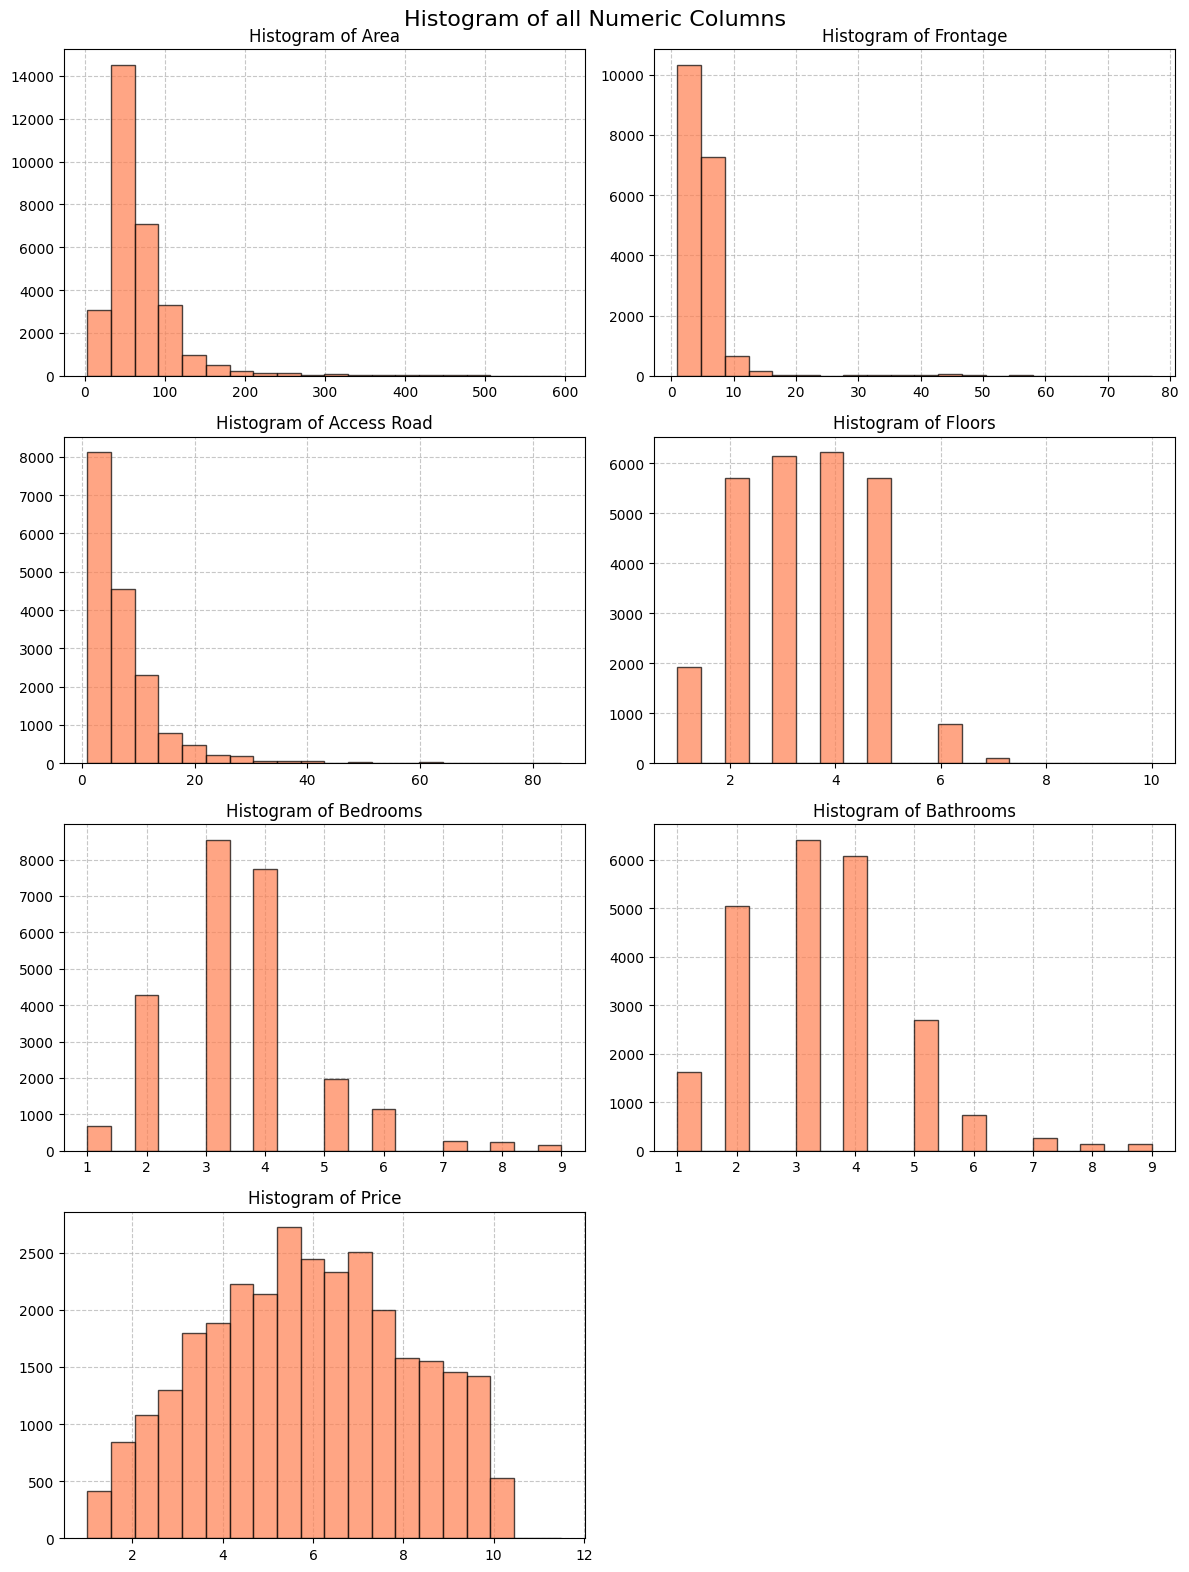

In [15]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.to_list()
categorical_cols = df.select_dtypes(include=['object', 'string', 'category']).columns.to_list()
vis.histogram(df, features=numeric_cols, bins=20, title='Histogram of all Numeric Columns')

Ta thấy rằng các biến số học đều có dạng phân phối chuẩn hoặc gần chuẩn, điều này giúp cho các mô hình tuyến tính như Linear Regression/Ridge/Lasso hoạt động tốt. Ngoài ra các mô hình Tree-based như Random Forest, XGBoost, CatBoost hay LightGBM cũng có thể dùng tốt cho dữ liệu có phân phối như này.

Ngoài ra, các cột này cũng có các ngoại lai với giá trị khá lớn, làm ảnh hưởng nhiều đến độ chính xác của mô hình dự đoán. Do đó, ta thực hiện cũng cần thực hiện loại bỏ các giá trị này.

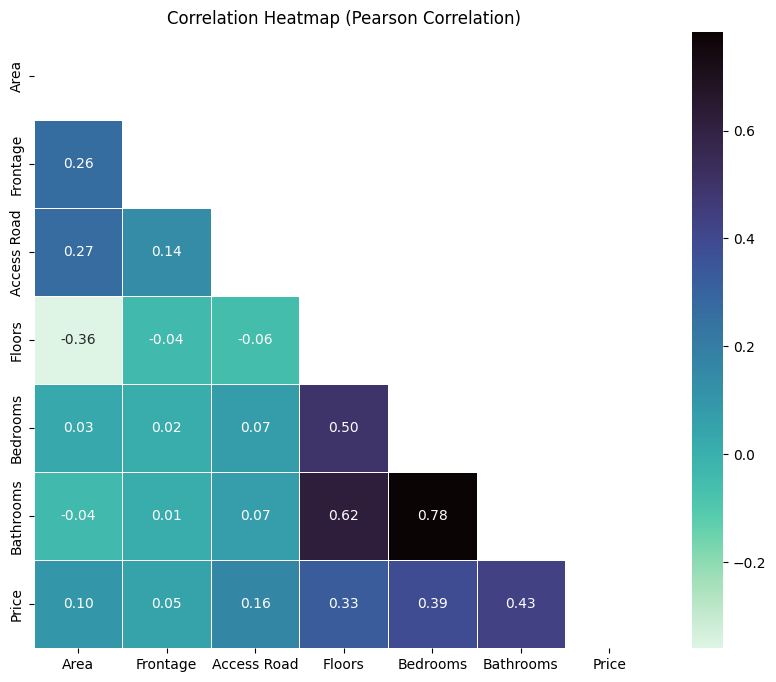

In [16]:
vis.heatmap(df)

Cột `Area` có hệ số tương quan Pearson với `Price` có độ lớn nhỏ, điều này trái ngược với thực tế vì diện tích đất ảnh hưởng rất nhiều đến giá tài sản 

$\Rightarrow$ Cần thực hiện Target Encoding cho cột Area này như sau: Tạo cột mới `new_address` bao gồm quận/huyện/thành phố + tỉnh/thành phố TW được trích xuất từ cột `Address` ban đầu và thực hiện Target Encoding bằng giá trị trung bình (mean)

Ngoài ra cột `Bathrooms` và `Bedrooms` có độ lớn của hệ số tương quan khá cao gây ra hiện tượng đa cộng tuyến (multicollinearity) do đó ta nên thử thực hiện Target Encoding bằng giá trị trung bình cho hai biến này.